# Neural networks

*Megan Courtman <megan.courtman@plymouth.ac.uk>*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/plymouth-neuroimaging/research-academy/blob/main/03_Keras/neural_networks.ipynb)

In this notebook, we will look at using Python libraries to apply neural networks to a medical imaging problem. 

## Definitions

### Artificial intelligence
Artificial intelligence (AI) is a broad term, coined in 1955, which generally describes agents that receive information from the environment and perform actions.

### Machine learning
Machine learning is a subset of AI, and describes algorithms that improve themselves without explicit instruction through exposure to data. There are many types of machine learning, many of which require manual feature selection.

### Deep learning
Deep learning is a subset of machine learning, in which layered neural networks are used to build representations of complicated concepts out of simpler concepts. In neural networks, the data passes from node to node in a structure that loosely resembles neurons in the brain. A distinctive aspect of deep learning is that it does not require manual feature selection or engineering, and can learn more abstract representations.

<div>
<img src="neural_network.png" width="400" />
</div>

#### Convolutional neural networks
A convolutional neural network (CNN) is a specific type of neural network that is used in image analysis. At each convolutional stage, a filter passes over the image to detect the presence of patterns. At the beginning of the network it picks up simple patterns (like straight lines, curves or corners). Later in the network these patterns will be combined to detect more complicated patterns. See image below for an example of CNN architecture, and the gif below for a visualisation of how the filter moves across the image.

<div>
<img src="cnn.png" width="750" />
</div>

<div>
<img src="cnn.gif" width="200" />
</div>

## AI and deep learning in radiology
Deep learning has been successfully applied to computer vision tasks such as object classification, localisation and detection. Many attempts have been made to translate these successes into radiological applications. There are now thousands of publications applying computer vision techniques to medical imaging.

### Advantages
The integration of AI into the radiological assessment workflow to provide radiologists with pre-screened images and identified features may have great benefits to offer, including enhanced efficiency and efficacy in diagnostics and the reduction of observational oversights and omissions. AI has the potential to detect patterns which are invisible to the human eye. It also has the potential to make healthcare more equitable, by being data-driven and (theoretically) not subject to human biases.

### Disadvantages
There have been many cases of AI being misused or poorly understood in healthcare research. An example which well illustrates many of the common pitfalls is the application of machine learning to detecting COVID-19 in chest radiographs and CT scans. Over 2000 papers were published on this subject between January and October 2020, but a [review](https://www.nature.com/articles/s42256-021-00307-0) found that **none** of the models in the 62 included studies were of  clinical use due to methodological flaws or underlying biases. It is very important that clinicians and computer scientists work together to foresee and mitigate such pitfalls. 

## Python libraries for deep learning

In this notebook we will be using [Keras](https://keras.io/), a neural network library for Python. This sits on top of [TensorFlow](https://www.tensorflow.org/), a machine learning library developed by Google. These are open-source libraries, which means that the source code is freely available for use and modification.

We will also be using other open-source Python libraries which will help us process and analyse the data. These include [Matplotlib](https://matplotlib.org/) for plotting images, [OpenCV](https://docs.opencv.org/4.x/) and [imutils](https://github.com/PyImageSearch/imutils) for image processing, [NumPy](https://numpy.org/) for working with arrays, [os](https://docs.python.org/3/library/os.html) for interacting with the operating system, and [Scikit-learn](https://scikit-learn.org/stable/index.html) for machine learning functionality.

## Example: brain tumour detection

For a quick example of using deep learning in Python for medical imaging, we will look at detecting brain tumours in MRI scans. We will use [a publicly available dataset hosted on Kaggle](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection).

This is a **supervised** machine learning problem. That means that the data has been labelled (in this case as containing a tumour or not), and we are training a neural network to work out these labels for itself. (In an **unsupervised** machine learning application, the model is not given any labels and finds patterns such as clusters in the data.)

In [1]:
# Install libraries onto machine
!python3 -m pip install opencv-python
!python3 -m pip install imutils
!python3 -m pip install matplotlib
!python3 -m pip install numpy
!python3 -m pip install scikit-learn
!python3 -m pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# Import libraries
import os

import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

2023-07-21 10:47:36.046356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 10:47:36.200196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 10:47:36.201176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 10:47:36.823323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# If you have not yet downloaded the data then set to "True"
download_data = False

if download_data:
    !wget https://github.com/plymouth-neuroimaging/research-academy/raw/main/03_Keras/data.zip
    !mkdir data
    !unzip data.zip -d data

### Load images

The images are in the folder `data` - in the subfolder `yes` if there is a tumour present and in `no` if a tumour is not present. 

When we prepare data for a supervised machine learning problem in Python, we typically create an array called `X` which contains the input data (in this case, images) and an array called `y` for the output labels that the model will be predicting.

In [4]:
labels = ["yes", "no"]
X = []
y = []

# Loop through both labels
for label in labels:
    path = "./data/" + label
    # Loop through all the files in the subfolder
    for file in os.listdir(path):
        if not file.startswith("."):
            # Read the image
            img = cv2.imread(path + "/" + file, 0)
            # Add the image to the images array
            X.append(img)
            # Add the label to the labels array
            y.append(label)
                    
print(f'{len(X)} images loaded.')

253 images loaded.


### Crop images

Here we will crop the images to the head. We will define a function to do this: don't worry about understanding the details of this.

In [5]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.GaussianBlur(img, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return set_new

In [6]:
X = crop_imgs(X)

### Resize images

We need to resize the images so that they are all the same size. This is required by the model.

In [7]:
IMG_SIZE = (224, 224)

In [8]:
def resize_imgs(set_name, img_size=(100,100)):
    """
    Resize
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(img)
    return np.array(set_new)

In [9]:
X = resize_imgs(X, (224,224))

### Show some images

Let's look at some examples of the images.

In [10]:
def plot_image(img):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(img, cmap='binary')
    ax.set_axis_off()
    plt.show()    

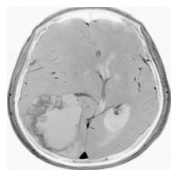

In [11]:
# Show tumour (first image)
plot_image(X[0])

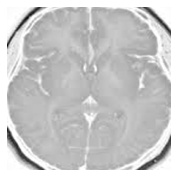

In [12]:
# Show no tumour (last image)
plot_image(X[-1])

### Split into training and test

In a machine learning problem, we separate the data into training and test data. We use the training data to show the model images and the labels associated with them. We then use the test data to show the model images and let it make its own predictions for labels for those images, which allows us to assess how well the model performs on unseen data.

We will split the data into 75% training data and 25% test data.

In [13]:
# Turn y into a binary label
y = np.array([1 if label == "yes" else 0 for label in y])

# Reshape X to have 1 channel
X = X.reshape(X.shape[0], IMG_SIZE[0], IMG_SIZE[1], 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

Now let's build the model structure. We will use layers provided by Keras to create a convolutional neural network.

In [117]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224,224,1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Let's look at a summary of the model:

In [118]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 activation_67 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_68 (Activation)  (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                

### Train model

Now we will train the model. 

We set the number of epochs to 250, which means that the data will pass through the model a maximum of 250 times.

We set the batch size to 8, which means that 8 images will pass through the model in one go.

We add "early stopping", so that if the model isn't improving after a certain amount of time (in this case, 50 epochs), then the model will stop training. This helps to prevent the model overfitting to the training data.

In [119]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=50,
                                                     restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    epochs=250,
                    batch_size=8,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping_cb],
                    verbose=1)

Epoch 1/250
24/24 [==============================] - 3s 91ms/step - loss: 3.5356 - accuracy: 0.5185 - val_loss: 0.6492 - val_accuracy: 0.7656
Epoch 2/250
24/24 [==============================] - 2s 87ms/step - loss: 0.6810 - accuracy: 0.6296 - val_loss: 0.5979 - val_accuracy: 0.7656
Epoch 3/250
24/24 [==============================] - 2s 87ms/step - loss: 0.6598 - accuracy: 0.6190 - val_loss: 0.6286 - val_accuracy: 0.7344
Epoch 4/250
24/24 [==============================] - 2s 87ms/step - loss: 0.6169 - accuracy: 0.6931 - val_loss: 0.5151 - val_accuracy: 0.7656
Epoch 5/250
24/24 [==============================] - 2s 86ms/step - loss: 0.5302 - accuracy: 0.7619 - val_loss: 0.4723 - val_accuracy: 0.7344
Epoch 6/250
24/24 [==============================] - 2s 87ms/step - loss: 0.4953 - accuracy: 0.7725 - val_loss: 0.4978 - val_accuracy: 0.6875
Epoch 7/250
24/24 [==============================] - 2s 87ms/step - loss: 0.4403 - accuracy: 0.8254 - val_loss: 0.4585 - val_accuracy: 0.7656
Epoch 

Let's plot the model's performance over time:

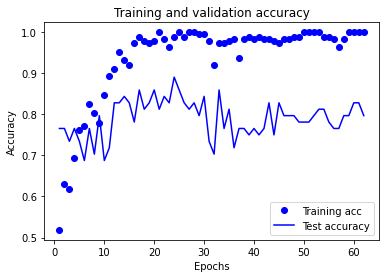

In [120]:
history_dict = history.history

acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Test accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

We can see that the model

In [121]:
probability = model.predict(X_test)
y_pred_test = probability >= 0.5
y_pred_test = y_pred_test.flatten()
accuracy_test = np.mean(y_pred_test == y_test)

2/2 [==============================] - 0s 60ms/step


In [122]:
accuracy_test

0.828125

### Show an example of a missed tumour

In [123]:
# Get missed tumours
missed = (y_pred_test == 0) & (y_test == 1)

In [124]:
missed_index = [i for i in range(len(missed)) if missed[i]]
missed_index

[19, 27, 34, 50, 52]

In [125]:
example = X_test[missed_index[0]]
example = example.reshape(example.shape[0], example.shape[1])

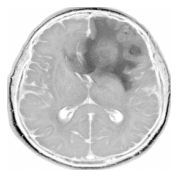

In [126]:
plot_image(example)

### How could we make the model better?

There are many things we could try, including:
* Different preprocessing
* Different model parameters
* Acquiring more data
* Data augmentation (artificially increasing the size of the existing dataset, e.g. by flipping and rotating the images)